# Patch Inference

Seed set to 0


weights


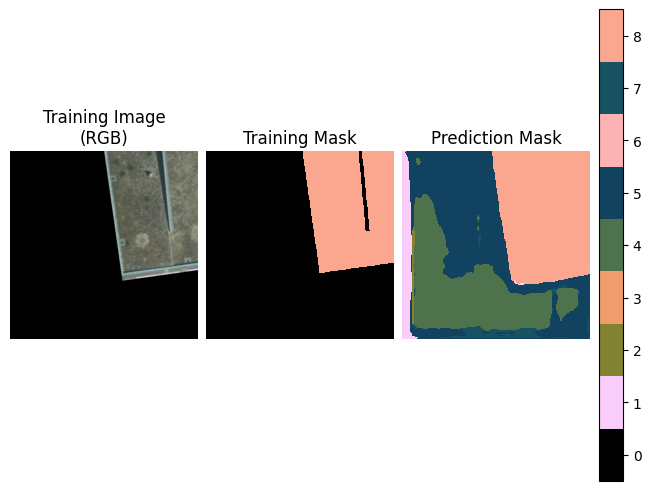

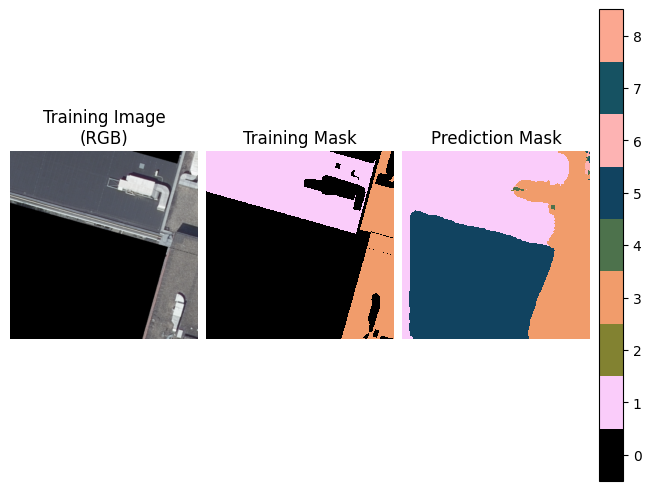

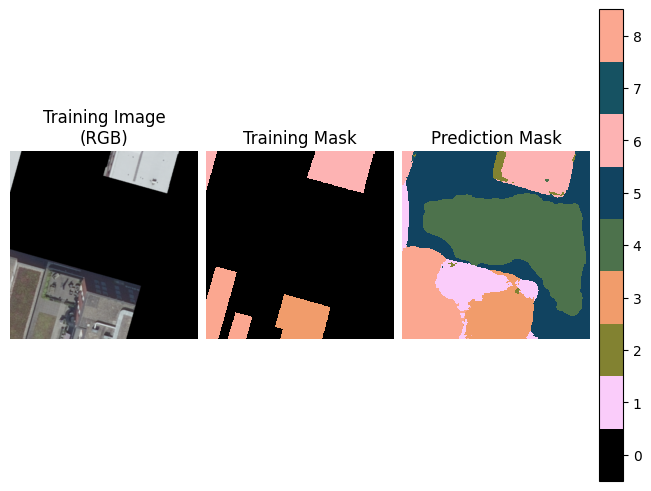

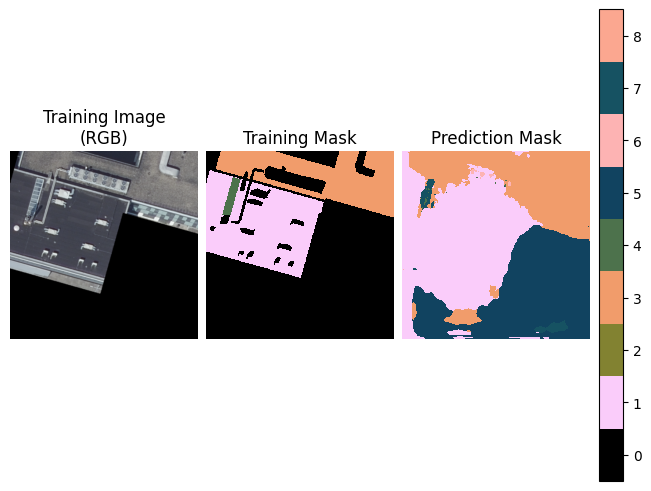

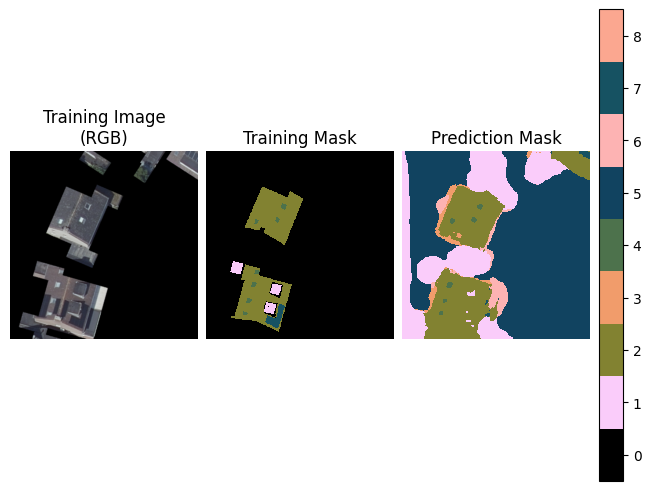

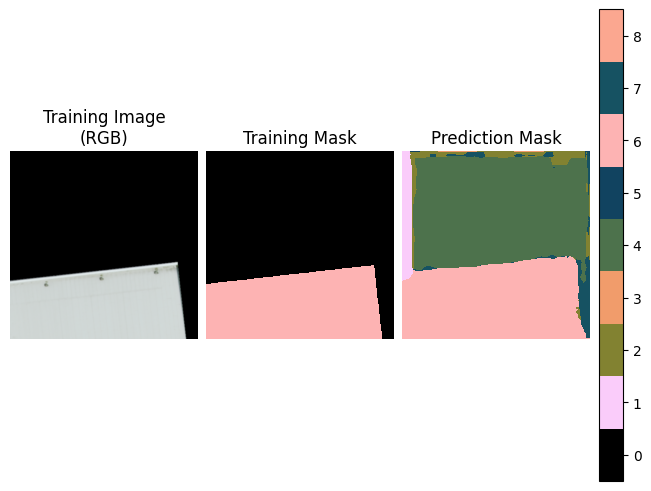

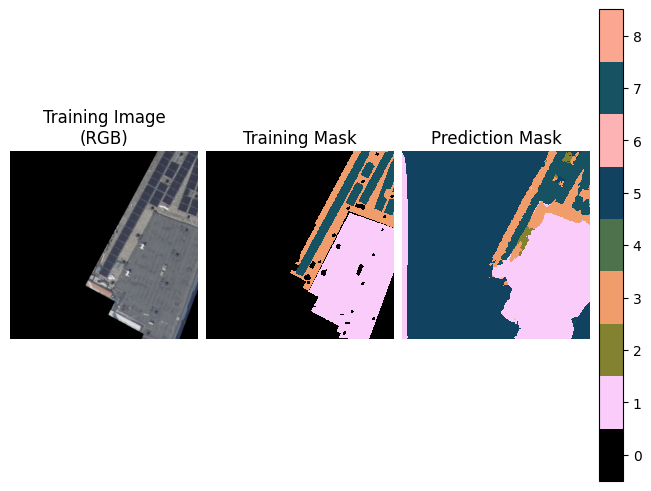

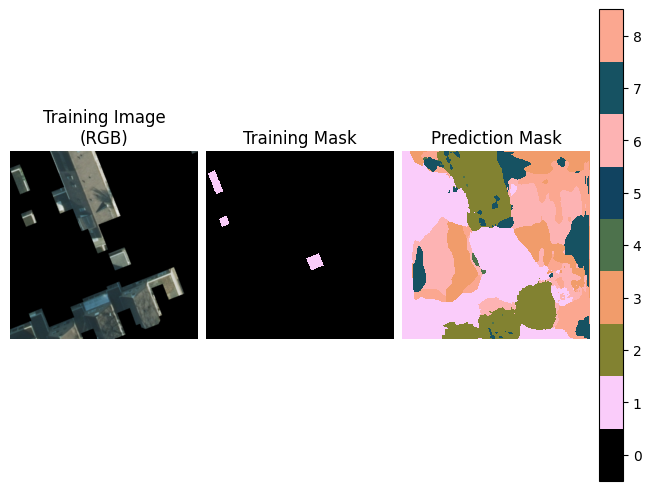

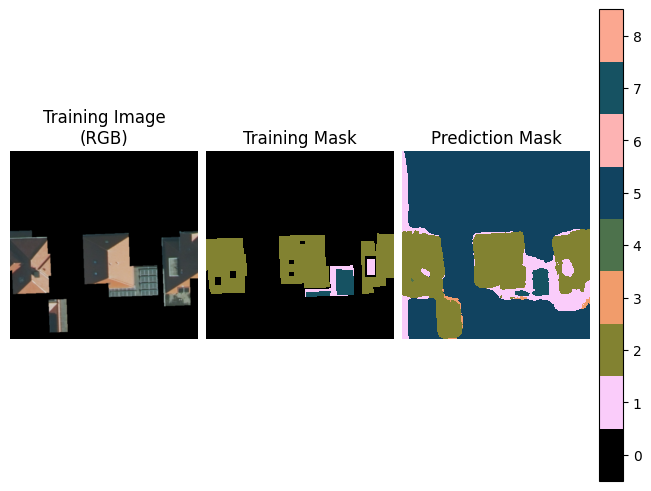

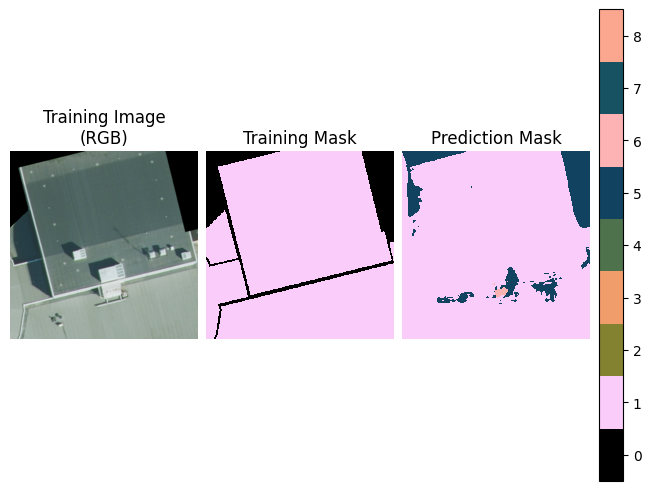

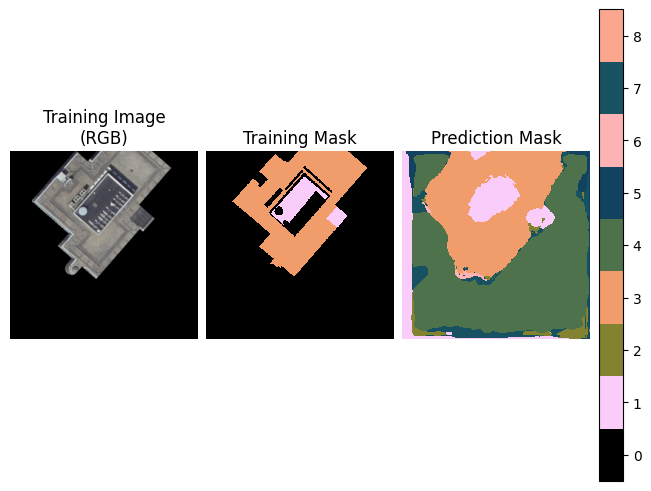

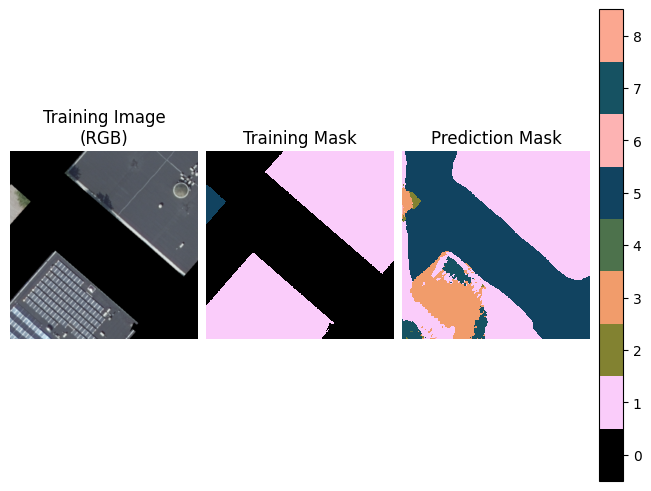

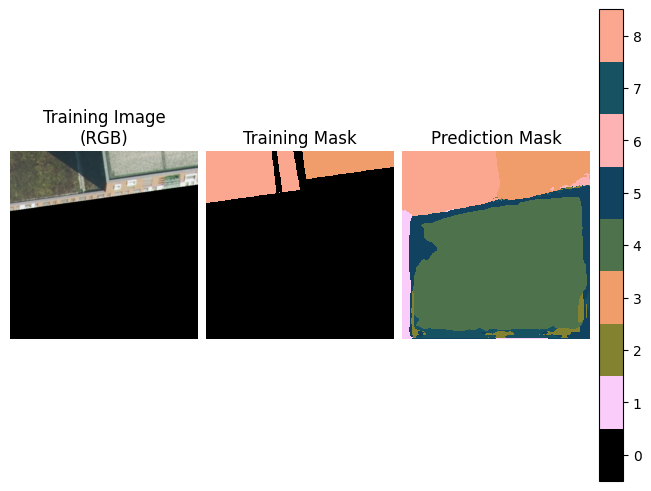

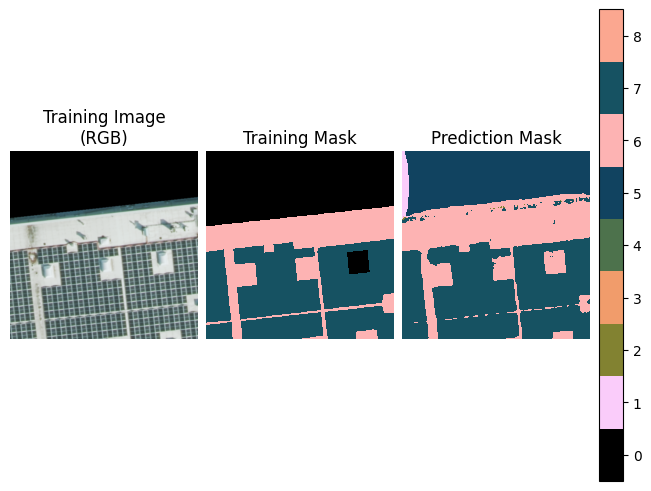

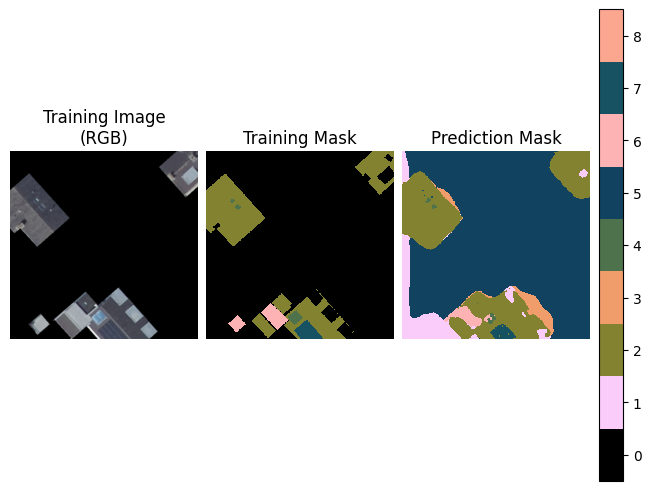

In [17]:
import lightning
import torch.cuda
import torchgeo.transforms

from common.augmentations import MinMaxScaling
from training.datamodule import TrainingDataModule
from training.dataset import TrainingDataset
from training.task import TrainingTask

lightning.pytorch.seed_everything(workers=True)

torch.set_float32_matmul_precision("high")
torch.backends.cudnn.allow_tf32 = True

datamodule = TrainingDataModule(root="../dataset/temp")
datamodule.setup("fit")

dataset: TrainingDataset = datamodule.val_dataset

model: TrainingTask = TrainingTask.load_from_checkpoint("../logs/RoofSense/best-v1.ckpt",
                                                        map_location="cuda" if torch.cuda.is_available() else "cpu")
model.eval()

scale = torchgeo.transforms.AugmentationSequential(MinMaxScaling(  # TODO: Expose these parameters in the initializer.
    mins=torch.tensor([0, 0, 0, 0, 0]), maxs=torch.tensor([255, 255, 255, 1, 90]), ), data_keys=["image"], )

for i in range(len(dataset)):
    batch = dataset[i]
    batch = scale(batch)
    image: torch.Tensor = batch["image"].to(model.device)
    with torch.inference_mode():
        prediction=model(image).argmax(dim=1).squeeze().cpu()
    batch["prediction"]=prediction
    dataset.plot(batch)